In [2]:
%matplotlib inline

from config import configs

import os
import io
import numpy as np
import matplotlib
import timeit
import random
import pprint
import deepdish as dd
import cv2

import matplotlib.pyplot as plt

from numba import njit, prange
from datetime import datetime
from skimage.transform import resize
from scipy.interpolate import griddata
from core.kitti import KITTI
from core.transforms_3D import transform, project
from pixor_utils.model_utils import load_model, save_model
from data_utils.training_gen import TrainingGenerator
from data_utils.generator import Generator, KITTIGen
from tt import bev
from pixor_targets import PIXORTargets
from pixor_utils.post_processing import nms_bev
from test_utils.unittest import test_pc_encoder, test_target_encoder
from encoding_utils.pointcloud_encoder import OccupancyCuboidKITTI
from encoding_utils.voxelizer import BEVVoxelizer

In [3]:
DS_DIR = os.path.expanduser(configs['dataset_path'])

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = configs["gpu_id"]
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

In [4]:
import tensorflow as tf
import tensorflow.keras.backend as K

device_name = tf.test.gpu_device_name()
os.system('clear')
print('Conncted to Device:', device_name)

Conncted to Device: /device:GPU:0


In [5]:
# Point Cloud Encoder
INPUT_SHAPE = configs['input_shape']

# Training
BATCH_SIZE = configs['hyperparams']['batch_size']
LEARNING_RATE = configs['hyperparams']['lr']
EPOCHS = configs['hyperparams']['epochs']
NUM_THREADS = configs['hyperparams']['num_threads']
MAX_Q_SIZE = configs['hyperparams']['max_q_size']

In [6]:
kitti = KITTI(DS_DIR, configs['training_target'])

train_ids = kitti.get_ids('train')
val_ids = kitti.get_ids('val')
micro_ids = kitti.get_ids('micro')

In [7]:
pc_encoder = OccupancyCuboidKITTI(0, 70, -40, 40, -1, 3, [0.1, 0.1, 4]) # 0.1, 0.1, 0.4
voxelizer  = BEVVoxelizer(n_x=448, n_y=512, n_z=32, side_range=(0,70), fwd_range=(-40,40), height_range=(-1, 3), filter_external=True)

In [8]:
cur_idx = train_ids[25]

In [9]:
pc, ref = kitti.get_velo(cur_idx, workspace_lim=((-40, 40), (-1, 3), (0, 70)), use_fov_filter=True)
print('pc.shape', pc.shape, 'ref.shape', ref.shape)

pc.shape (3, 17369) ref.shape (1, 17369)


In [10]:
encoded_pc = pc_encoder.encode(pc.T)
print('encoded_pc.shape', encoded_pc.shape)

encoded_pc.shape (700, 800, 1)


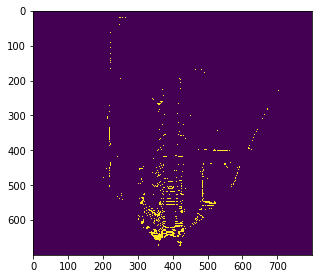

In [11]:
plt.figure(figsize = (5, 5))
plt.imshow(np.squeeze(encoded_pc))

In [12]:
voxelized_pc = voxelizer.encode(pc)

In [13]:
print(np.sum(voxelized_pc))
print(voxelized_pc.shape)

7396.0
(448, 512, 32)


In [14]:
bev = np.sum(voxelized_pc, axis=2)
bev = bev / np.amax(bev)
print('bev.shape', bev.shape)
print(np.amin(bev), np.amax(bev), np.mean(bev))
print(np.amin(encoded_pc), np.amax(encoded_pc), np.mean(encoded_pc))

bev.shape (448, 512)
0.0 1.0 0.0023031428
0.0 1.0 0.0121535715


In [14]:
def bev2world(idx, jdx, bev_width, bev_length, world_width, world_length):
    disc_factor_w, disc_factor_l = world_width / bev_width, world_length / bev_length
    return np.array([idx * disc_factor_w - world_width / 2., 1., (bev_length - jdx) * disc_factor_l])
#     return idx * disc_factor_w - world_width / 2., 1., (bev_length - jdx) * disc_factor_l

# # 512x448
# assert bev2world(0  ,   0, 512, 448, 80, 70) == (-40., 1., 70. )
# assert bev2world(256, 224, 512, 448, 80, 70) == (0.  , 1., 35. )
# assert bev2world(128, 112, 512, 448, 80, 70) == (-20., 1., 52.5)
# assert bev2world(384, 336, 512, 448, 80, 70) == (20. , 1., 17.5)
# assert bev2world(512, 448, 512, 448, 80, 70) == (40. , 1., 0.  )

# # 256x224
# assert bev2world(0   // 2, 0   // 2, 512 // 2, 448 // 2, 80, 70) == (-40., 1., 70. )
# assert bev2world(256 // 2, 224 // 2, 512 // 2, 448 // 2, 80, 70) == (0.  , 1., 35. )
# assert bev2world(128 // 2, 112 // 2, 512 // 2, 448 // 2, 80, 70) == (-20., 1., 52.5)
# assert bev2world(384 // 2, 336 // 2, 512 // 2, 448 // 2, 80, 70) == (20. , 1., 17.5)
# assert bev2world(512 // 2, 448 // 2, 512 // 2, 448 // 2, 80, 70) == (40. , 1., 0.  )

# # 128x112
# assert bev2world(0   // 4, 0   // 4, 512 // 4, 448 // 4, 80, 70) == (-40., 1., 70. )
# assert bev2world(256 // 4, 224 // 4, 512 // 4, 448 // 4, 80, 70) == (0.  , 1., 35. ) 
# assert bev2world(128 // 4, 112 // 4, 512 // 4, 448 // 4, 80, 70) == (-20., 1., 52.5)
# assert bev2world(384 // 4, 336 // 4, 512 // 4, 448 // 4, 80, 70) == (20. , 1., 17.5)
# assert bev2world(512 // 4, 448 // 4, 512 // 4, 448 // 4, 80, 70) == (40. , 1., 0.  )

# # 64x56
# assert bev2world(0   // 8, 0   // 8, 512 // 8, 448 // 8, 80, 70) == (-40., 1., 70. )
# assert bev2world(256 // 8, 224 // 8, 512 // 8, 448 // 8, 80, 70) == (0.  , 1., 35. )
# assert bev2world(128 // 8, 112 // 8, 512 // 8, 448 // 8, 80, 70) == (-20., 1., 52.5)
# assert bev2world(384 // 8, 336 // 8, 512 // 8, 448 // 8, 80, 70) == (20. , 1., 17.5)
# assert bev2world(512 // 8, 448 // 8, 512 // 8, 448 // 8, 80, 70) == (40. , 1., 0.  )

In [15]:
def get_nearest_pt(pt, pts):
    dist = np.sum((pts - pt) ** 2, axis=0)
    return pts[:, np.argmin(dist)]

In [16]:
pt = bev2world(512 // 4, 448 // 4, 512 // 4, 448 // 4, 80, 70).reshape((3, 1))
pt.tolist(), get_nearest_pt(pt, pc).tolist()

([[40.0], [1.0], [0.0]],
 [18.056564142384953, 0.46906555720351, 20.67108498202348])

In [17]:
_, _, P2 = kitti.get_calib(cur_idx)

In [1]:
def get_world_pts(bev_width, bev_length):
    world_pts = []
    for i in prange(bev_length):
        for j in prange(bev_width):
            world_pt = bev2world(j, i, bev_width, bev_length, 80, 70).reshape((3, 1))
            world_pts.append(world_pt)
    nearest = []
    geo_feature = []
    for world_pt in world_pts:
        nearest_pt = get_nearest_pt(world_pt, pc)
        nearest.append(nearest_pt.tolist())
        geo_feature.append((nearest_pt - np.squeeze(world_pt)).tolist())
    nearest = np.array(nearest).T
    geo_feature = np.array(geo_feature)
    nearest_projected = project(P2, nearest).astype(np.int32).T
    return np.concatenate((nearest_projected.reshape((bev_length, bev_width, 2)), 
                          geo_feature.reshape((bev_length, bev_width, 3))), axis=-1)
factor = 8
print(bev.shape[0] // factor, bev.shape[1] // factor)
mapping = get_world_pts(bev.shape[1] // factor, bev.shape[0] // factor)
print('mapping.shape', mapping.shape)

NameError: name 'bev' is not defined

In [26]:
img = kitti.get_image(cur_idx)
print('img.shape', img.shape)

img.shape (375, 1242, 3)


In [31]:
new_bev = np.zeros((224, 256, 3))
for i in range(mapping.shape[0]):
    for j in range(mapping.shape[1]):
        new_bev[i,j] = img[int(mapping[i,j,1]), int(mapping[i,j,0])]

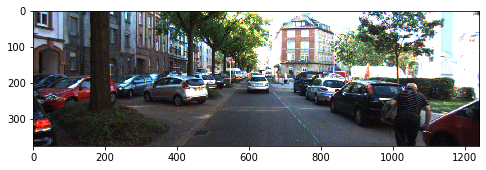

In [32]:
plt.figure(figsize = (8, 8))
plt.imshow(img)

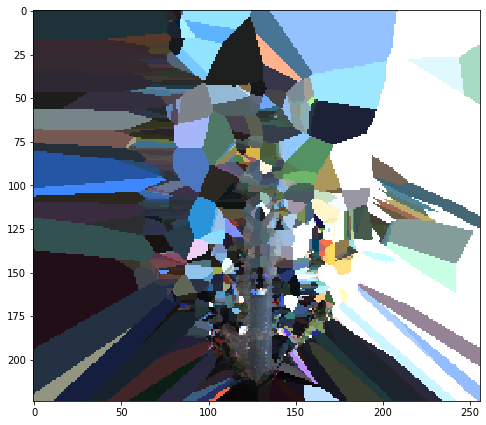

In [33]:
plt.figure(figsize = (8, 8))
plt.imshow(new_bev)

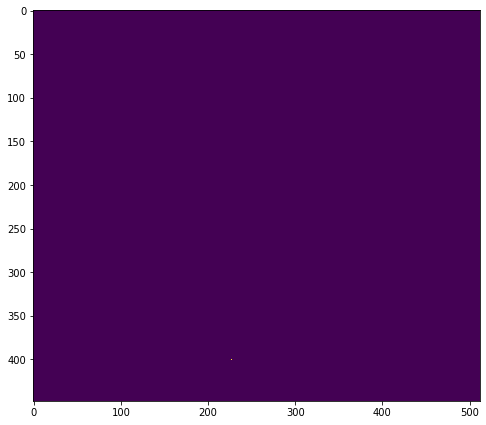

In [16]:
plt.figure(figsize = (8, 8))
plt.imshow(bev)

In [92]:
# plt.figure(figsize = (20,20))
# plt.imshow(np.squeeze(encoded_pc))

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20))
# # ax1.axis('off')
# ax1.imshow(np.squeeze(bev), cmap='gray')
# # ax2.axis('off')
# ax2.imshow(np.squeeze(encoded_pc), cmap='gray')